In [121]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression, Ridge, SGDClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Загружаем данные

In [13]:
train_df = pd.read_csv('in.dta.txt', delim_whitespace=True, names=['x1', 'x2', 'target'])
test_df = pd.read_csv('out.dta.txt', delim_whitespace=True, names=['x1', 'x2', 'target'])

In [18]:
print('Train')
display(train_df.head())
print('Test')
test_df.head()

Train


,x1,x2,target
0,-0.779470,0.838221,1.0
1,0.155635,0.895377,1.0
2,-0.059908,-0.717780,1.0
3,0.207596,0.758933,1.0
4,-0.195983,-0.375487,-1.0


Test


,x1,x2,target
0,-0.106006,-0.081467,-1.0
1,0.177930,-0.345951,-1.0
2,0.102162,0.718258,1.0
3,0.694078,0.623397,-1.0
4,0.023541,0.727432,1.0


# Препроцессинг

In [27]:
def generate_features(df):
    res_df = df.copy()
    res_df['x1_2'] = res_df['x1']**2
    res_df['x2_2'] = res_df['x2']**2
    res_df['x1x2'] = res_df['x1']*res_df['x2']
    res_df['mode_sub'] = (res_df['x1'] - res_df['x2']).abs()
    res_df['mode_add'] = (res_df['x1'] + res_df['x2']).abs()
    return res_df
    
train_wide = generate_features(train_df)
test_wide = generate_features(test_df)
train_wide.head()

,x1,x2,target,x1_2,x2_2,x1x2,mode_sub,mode_add
0,-0.779470,0.838221,1.0,0.607574,0.702615,-0.653369,1.617692,0.058751
1,0.155635,0.895377,1.0,0.024222,0.801701,0.139352,0.739743,1.051012
2,-0.059908,-0.717780,1.0,0.003589,0.515208,0.043001,0.657872,0.777688
3,0.207596,0.758933,1.0,0.043096,0.575980,0.157552,0.551337,0.966530
4,-0.195983,-0.375487,-1.0,0.038409,0.140991,0.073589,0.179504,0.571470


In [51]:
X = train_wide.drop(columns=['target'])
y = train_wide['target']

X_test = test_wide.drop(columns=['target'])
y_test = test_wide['target']

# Обучение модели без классификатора

In [63]:
regr = LinearRegression()
regr.fit(X,y)
y_pred = regr.predict(X)

y_pred_test = regr.predict(X_test)

In [73]:
def compute_print_errors(y_true, y_pred, etype, verbose=True):
    y_pred[y_pred<0] = -1
    y_pred[y_pred>=0] = 1
    E = accuracy_score(y_true, y_pred)
    if verbose:
        print(f'Ошибка {etype}: {E}')
    return E

print('Ошибки классификации:')
E_in = compute_print_errors(y, y_pred, 'обучение')
E_out = compute_print_errors(y_test, y_pred_test, 'валидация')


Ошибки классификации:
Ошибка обучение: 0.9714285714285714
Ошибка валидация: 0.916


# Попробуем другой регрессор

In [88]:
# Без регуляризации:
regr2 = Ridge(alpha=0, random_state=42)
regr2.fit(X,y)
y_pred2 = regr2.predict(X)
y_pred_test2 = regr2.predict(X_test)

print('Ошибки классификации:')
E_in = compute_print_errors(y, y_pred2, 'обучение')
E_out = compute_print_errors(y_test, y_pred_test2, 'валидация')

# Очевидно реализация линейного регрессора точно такая же

Ошибки классификации:
Ошибка обучение: 0.9714285714285714
Ошибка валидация: 0.916


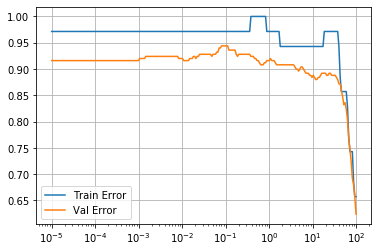

In [123]:
# С регуляризацией:
E_in = []
E_out = []
alphas = np.logspace(-5, 2, num=250)
for alpha in alphas:
    regr_ridge = Ridge(alpha=alpha, random_state=42)
    regr_ridge.fit(X,y)
    y_pred3 = regr_ridge.predict(X)
    y_pred_test3 = regr_ridge.predict(X_test)
    E_in.append(compute_print_errors(y, y_pred3, 'обучение', verbose=False))
    E_out.append(compute_print_errors(y_test, y_pred_test3, 'валидация', verbose=False))

plt.semilogx(alphas, E_in, label='Train Error')
plt.semilogx(alphas, E_out, label='Val Error')
plt.grid(True)
plt.legend(loc='best')
plt.show()

In [124]:
opt_ind = np.argmax(E_out)
print('Лучшее значение коэф регуляризации', alphas[opt_ind])
print('Лучшая точность на валидации', E_out[opt_ind])

Лучшее значение коэф регуляризации 0.0808407850059402
Лучшая точность на валидации 0.944


# Попробуем классификатор

Loss type hinge
Лучшее значение коэф регуляризации 0.00954815979727402
Лучшая точность на валидации 0.956


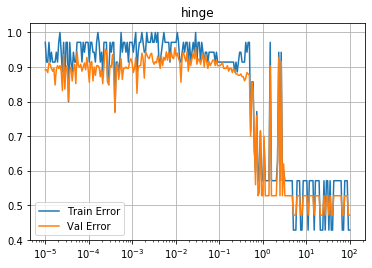

Loss type modified_huber
Лучшее значение коэф регуляризации 0.05138582972943202
Лучшая точность на валидации 0.956


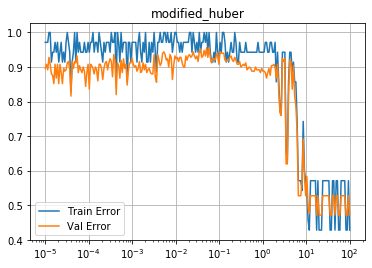

Loss type log
Лучшее значение коэф регуляризации 0.002791149716375385
Лучшая точность на валидации 0.956


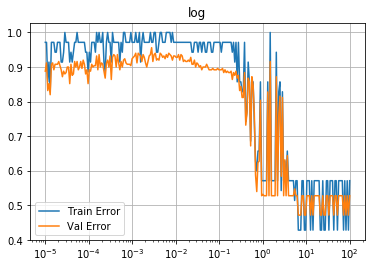

In [128]:
for loss in ["hinge", "modified_huber", "log"]:
    
    E_in = []
    E_out = []
    alphas = np.logspace(-5, 2, num=250)
    for alpha in alphas:
        clf = SGDClassifier(loss=loss, penalty='l2', alpha=alpha)
        clf.fit(X,y)
        y_pred = clf.predict(X)
        y_pred_test = clf.predict(X_test)
        E_in.append(accuracy_score(y, y_pred))
        E_out.append(accuracy_score(y_test, y_pred_test))
    print('Loss type', loss)
    opt_ind = np.argmax(E_out)
    print('Лучшее значение коэф регуляризации', alphas[opt_ind])
    print('Лучшая точность на валидации', E_out[opt_ind])
    
    plt.semilogx(alphas, E_in, label='Train Error')
    plt.semilogx(alphas, E_out, label='Val Error')
    plt.title(loss)
    plt.grid(True)
    plt.legend(loc='best')
    plt.show()

# Выводы
Линейная регрессия показывает результат чуть хуже, чем модели с нелинейным ядром - логистическая регрессия, SVM или модифицированный SVM.
При этом удивительно, что все модели с нелинейным ядром показывают одинаковую точность, если хорошо подобрать коэффициент регуляризации!
По-видимому, они достигают предела точности на данном датасете - есть несколько семплов, которые никакая из моделей правильно классифицировать не может.

Сама регуляризация улучшает результат для любой линейной модели, что линейная регрессия, что логистичская или SVM.